# Interactive clustering example

Here we will use the new interactive tool for interactive clustering.

You can integrate this with your workflow to fix clustering issues. To illustrate, I've duplicated the first part of the analysis template here. We then correct a clustering issue with the interactive clustering tool, and pipe the droplets DataFrame back into the rest of the pipeline (not shown here). 

### Step 0: Imports and config

Begin as normal. 

In [42]:
# basic imports 

import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Append top level directory with kchip package
import sys
sys.path.append('../../../')

# kchip imports
import kchip.io as kchip_io
import kchip.analyze as kchip_analyze

# Other
%matplotlib inline

# Read in config file
with open('config.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile)
    
print yaml.dump(config)

barcodes:
  cluster:
    eps: 0.02
    min_samples: 8
    offset:
    - 0
    - 0
    - 0
    points_to_cluster: 2000
  path: Notes_20191217_PAO1.xlsx
image:
  background_image: background_ave_gauss10
  base_path: 20191212_diag_kchip_PAO1
  base_path2: ''
  bugs: 3
  dyes:
  - 0
  - 1
  - 2
  names:
    premerge: 20191212_diag_kchip_PAO1_premerge
    t0: 20191212_diag_kchip_PAO1_t0
    t1: 20191212_diag_kchip_PAO1_t3
  overlap: 0.05
  pixel_size: 6.5
  rescale:
  - 1.4
  - 1
  - 1.7
  - 1
  size: 1024
  well_start_image:
  - 1
  - 2
  well_start_xy:
  - 540
  - 140
well_mask:
  filename: kchip/well_mask.tif
  pixel_size: 8.33625
  well_start_xy:
  - 850
  - 522



/Users/mzhu/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [43]:
fontsize = 14
plt.rcParams['axes.spines.right']=False
plt.rcParams['axes.spines.top']=False

plt.rcParams['axes.linewidth']=3
plt.rcParams['axes.labelsize']=fontsize
plt.rcParams['lines.linewidth']=2
plt.rcParams['xtick.labelsize']=fontsize
plt.rcParams['ytick.labelsize']=fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size']=fontsize
plt.rcParams['xtick.major.width']=1.5
plt.rcParams['ytick.major.width']=1.5
plt.rcParams['contour.negative_linestyle'] = 'solid'

plt.rcParams['savefig.bbox']='Tight'
plt.rcParams['pdf.fonttype'] = 42

### Step 1: Create droplets DataFrame

Here we won't run the code, instead we will just load the droplets DataFrame normally output by this cell from `droplets.csv`.

In [44]:
# Don't run for this example, instead just read in the droplets dataframe output by this cell
droplets = pd.read_csv('droplets_found_GB_corrected_20191217_PAO1.csv',index_col=0)
# config['barcodes']['path']='Notes_190503_3.xlsx'

# # Initialize droplets DataFrame from images
# droplets, rotation_theta = kchip_analyze.initialize_droplets(config)

# print 'Rotation (degrees): ', rotation_theta*180/np.pi

# # Identify droplets in the same well from fit to masks
# droplets = kchip_analyze.fit_droplets_to_mask(config,droplets,rotation_theta)

# # Cluster droplets and map apriori labels to clusters
# droplets, centroids = kchip_analyze.identify_clusters(config,droplets,show=1)

# print 'Total droplets identified: ', droplets.shape[0]

KeyError: 9

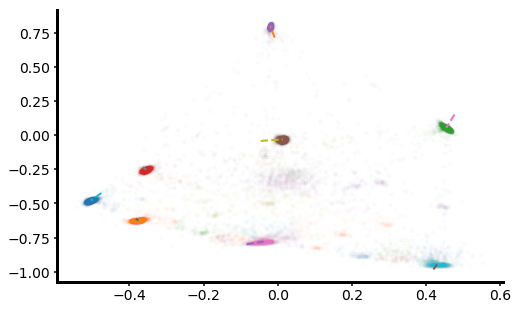

In [47]:
# Mess up clustering parameters to force bad clustering, for illustration
# config['barcodes']['cluster']['eps'] = 0.035
config['barcodes']['cluster']['min_samples'] = 4


fig, ax = plt.subplots(figsize=(8,5))

# Identify the clusters (using DBSCAN)
droplets = kchip_analyze.identify_clusters(config,droplets,show=1,ax=ax)[0]

# Map the cluster centroids to labels
droplets = kchip_analyze.map_labels_to_clusters(config,droplets,show=1,ax=ax)[0]

In [49]:
droplets

,IndexX,IndexY,ImageX,ImageY,R,oldG,oldB,RX,RY,Well_ID,Hash,G,B,PlaneX,PlaneY,Cluster
0,8,1,558,424,21640.304,4260.40,9503.952,558.0,424.0,77.0,-8822300284243858963,4070.32096,9205.7240,-0.503202,-0.472698,2
1,8,1,324,496,17230.528,6618.88,6101.640,324.0,496.0,39.0,-8822300284125023965,6496.84720,5638.3184,-0.365518,-0.615993,7
5,8,1,762,495,245.168,15735.12,18596.708,762.0,495.0,254.0,-8822300284039975388,15363.18584,17495.2496,0.456688,0.057000,0
6,8,1,620,496,20728.512,4122.76,9198.632,620.0,496.0,147.0,-8822300283989878281,3938.78736,8910.0388,-0.500031,-0.469283,2
7,8,1,148,494,23122.288,4520.60,9973.220,148.0,494.0,243.0,-8822300284027159849,4321.13560,9656.7780,-0.506767,-0.479422,2
8,8,1,28,494,241.472,14147.08,16439.952,28.0,494.0,142.0,-8822300284021334604,13818.28096,15449.6564,0.460084,0.047100,0
9,8,1,559,474,439.040,16741.76,19304.248,559.0,474.0,139.0,-8822300284017839457,16355.67504,18132.3248,0.455711,0.038297,0
10,8,1,589,472,18050.872,6797.48,6280.820,589.0,472.0,214.0,-8822300284067936564,6671.86360,5804.9964,-0.372743,-0.619690,7
12,8,1,502,473,17890.600,6769.44,6206.428,502.0,473.0,43.0,-8822300284129684161,6645.31144,5732.5672,-0.371518,-0.621219,7
13,8,1,413,471,307.384,16017.92,19037.280,413.0,471.0,129.0,-8822300284006188967,15637.17440,17916.0256,0.452733,0.058223,0


We can load the interactive tool to correct this. 

In [48]:
# Import the interactive tools
import kchip.tools.interact as interact


# Create InteractiveCluster object
centroids = droplets.groupby('Cluster')[['PlaneX','PlaneY']].median().values
rc = interact.InteractiveCluster(droplets[['PlaneX','PlaneY']].values[-5000:,:],centroids)

Don't forget to call `interact.bqplt.show()` in order to show the plot. You can now click on points to add a cluster, or click on the cluster centroid to remove the cluster. As you add and remove the points will re-cluster in response. 

In [50]:
# import bqplot as bqplt
# Show the plot
interact.bqplt.show()

# Change the point opacities for better viewing, as desired
rc.sca_points.default_opacities = [0.25]

VkJveChjaGlsZHJlbj0oRmlndXJlKGF4ZXM9W0F4aXMob3JpZW50YXRpb249J3ZlcnRpY2FsJywgc2NhbGU9TGluZWFyU2NhbGUoKSwgc2lkZT11J2xlZnQnKSwgQXhpcyhzY2FsZT1MaW5lYXLigKY=


After we are satisfied, we can then update the droplets DataFrame. 

In [51]:
# Update the droplets dataframe with new cluster assignments

droplets['Cluster']=rc.cluster(droplets[['PlaneX','PlaneY']].values)

Finally, remap the barcodes to the cluster centroids using `map_labels_to_clusters`.

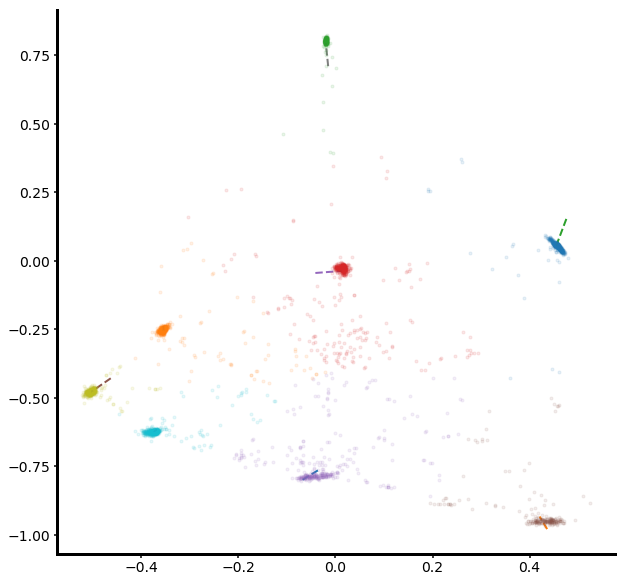

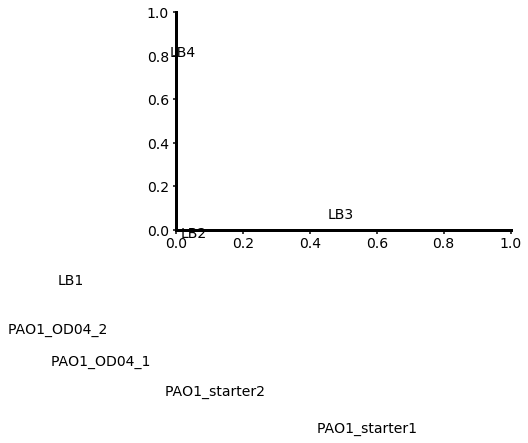

In [52]:
fig, ax = plt.subplots(figsize=(10,10))

# Use the updated cluster centroids from the interactive plot
droplets = kchip_analyze.map_labels_to_clusters(config,droplets,show=1,ax=ax)[0]

# Replot the points to view the clusters

d = droplets.loc[:5e3] # only choose the first 5000 points so we don't overload matplotlib
for item in droplets['Cluster'].unique():
    xy = d.query('Cluster=='+str(item))[['PlaneX','PlaneY']].values
    ax.plot(xy[:,0],xy[:,1],'.',alpha=0.1)

# plt.savefig('clusters_scaled_corr_181215_threshold42_pixels1pt5x.png',bbox_inches='tight')

The droplets DataFrame can then be carried forward through the rest of the analysis as usual. 

In [53]:
# Save as csv, reload that into analysis notebook!!!

droplets.to_csv('191209_Flu_droplets_clustered_corrected.csv')

In [13]:
droplets.head()

,IndexX,IndexY,ImageX,ImageY,R,xxx,yyy,RX,RY,Well_ID,Hash,G,B,PlaneX,PlaneY,Cluster,Label,Barcode
0,10,1,68,340,4272.40,3992.40,18858.16,68.0,340.0,77.0,-6299898719257419361,3615.2368,18578.6920,-0.024830,0.403949,24,Target14,"[25, 5, 20]"
1,10,1,96,394,7692.32,11154.80,4654.00,96.0,394.0,215.0,-6299898719376254359,11061.7200,3873.1640,0.148909,-0.657654,28,crRNA8,"[5, 20, 25]"
2,10,1,216,394,17658.08,520.88,4117.92,216.0,394.0,116.0,-6299898719191011568,438.5216,4081.4584,-0.776423,-0.631937,4,crRNA1,"[5, 0, 45]"
3,10,1,397,390,16970.20,428.64,3866.24,397.0,390.0,148.0,-6299898719451982544,351.3152,3836.2352,-0.785475,-0.637368,4,crRNA1,"[5, 0, 45]"
4,10,1,243,388,3054.40,20148.80,9874.80,243.0,388.0,9.0,-6299898719336642693,19951.3040,8464.3840,0.536920,-0.462068,26,Target27,"[10, 25, 15]"


In [138]:
droplets = droplets.drop(labels=['Label','PlaneX','PlaneY','Cluster','Barcode'],axis=1)

In [2]:
droplets = pd.read_csv('181219_chip3_UV7_corrected.csv',index_col=0)

In [31]:
# Tells you # of droplets with each label, sanity check for possible mis-assignment

all_counts = droplets['Label'].value_counts()
all_counts
# need to swap: Target16-crRNA15 and Target21-crRNA5 and Target20-crRNA4

crRNA27     1714
Target21    1704
crRNA21     1703
crRNA17     1672
crRNA18     1666
crRNA24     1664
crRNA20     1649
crRNA22     1639
crRNA19     1601
crRNA7      1595
crRNA23     1577
crRNA25     1570
crRNA16     1560
crRNA6      1547
crRNA9      1534
crRNA26     1533
crRNA14     1521
crRNA12     1518
crRNA13     1517
crRNA10     1516
Target16    1515
crRNA1      1513
crRNA3      1481
crRNA2      1477
crRNA11     1473
crRNA8      1463
Target20    1417
Target8     1284
Target12    1263
Target11    1254
Target6     1247
Target2     1236
Target13    1233
Target24    1228
Target25    1222
Target5     1211
Target4     1209
Target17    1193
crRNA15     1179
Target15    1172
Target1     1171
crRNA4      1165
Target3     1162
Target7     1158
Target23    1151
Target9     1149
Target14    1141
Target22    1112
Target19    1092
Target27    1084
Target18    1049
Target10    1041
crRNA5      1036
Target26     995
Target28     630
Name: Label, dtype: int64

In [10]:
all_counts['Target12'], all_counts['crRNA1'], all_counts['Target2'],all_counts['crRNA2']

(1007, 23909, 1011, 22890)

In [13]:
# Columns tell you the centroid of the clusters and calculates the distance between droplets and centroid
droplets['CentroidX'] = droplets.groupby('Label')['PlaneX'].transform('median')
droplets['CentroidY'] = droplets.groupby('Label')['PlaneY'].transform('median')
droplets['distance'] = np.sqrt((droplets.PlaneX-droplets.CentroidX)**2+(droplets.PlaneY-droplets.CentroidY)**2)


(0, 0.06)

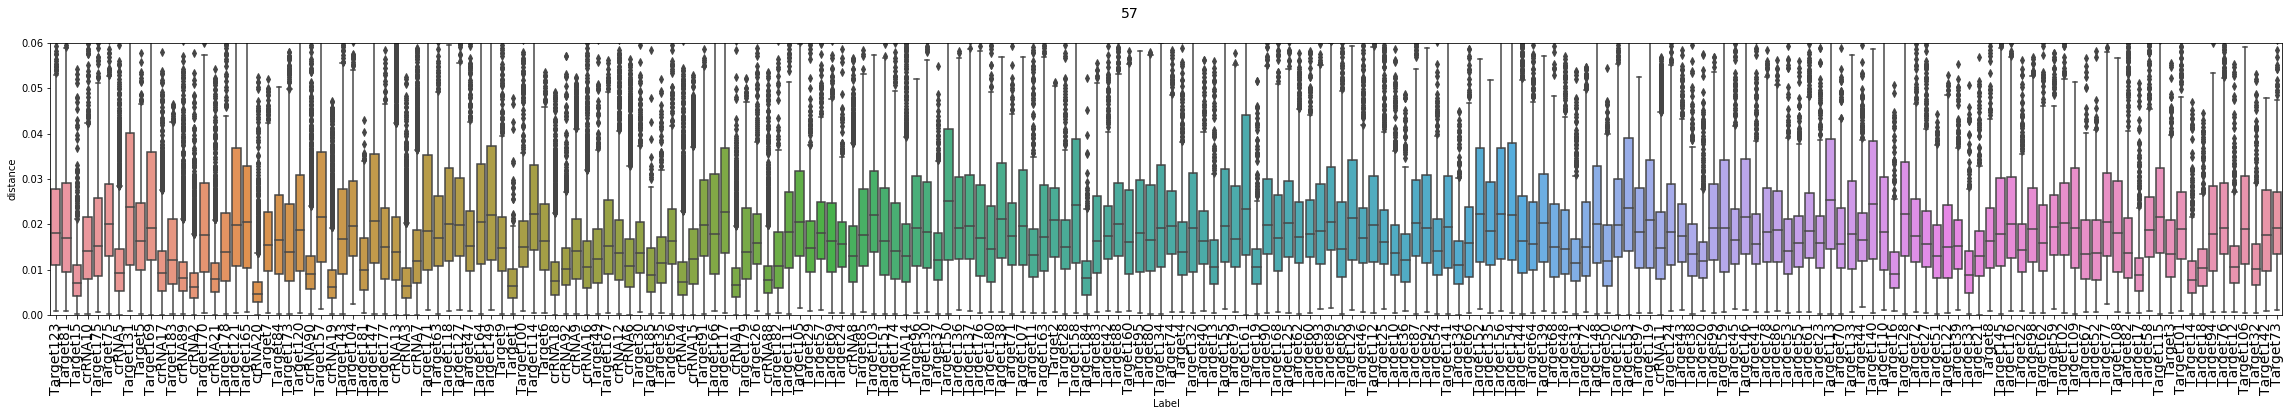

In [14]:
# Graphs median distance and distribution of droplet distances to the centroid
import seaborn as sns


# To test barcode distances:
fig, ax = plt.subplots(1,1, figsize=(40,5))
fig.suptitle(str(item), size=14)

sns.boxplot(x='Label',y='distance',data=droplets)
g = ax.get_xticklabels()
ax.set_xticklabels(g, rotation=90, size=14)
ax.set_ylim(0,0.06)

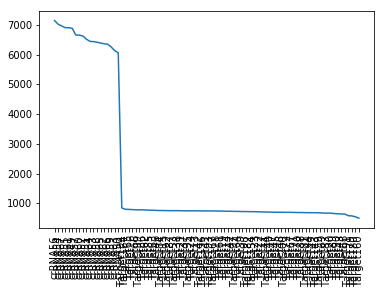

In [39]:
fig, ax = plt.subplots()
plt.plot(all_counts)
ax.set_xticklabels(all_counts.index.tolist(),size=10,rotation=90)
plt.show()

In [40]:
print float(10/3)

3.0


In [17]:
g

<a list of 9 Text yticklabel objects>

In [15]:
droplets['CentroidX'] = droplets.groupby('Label')['PlaneX'].transform('mean')
droplets['CentroidY'] = droplets.groupby('Label')['PlaneY'].transform('mean')
droplets['distance'] = np.sqrt((droplets.PlaneX-droplets.CentroidX)**2+(droplets.PlaneY-droplets.CentroidY)**2)



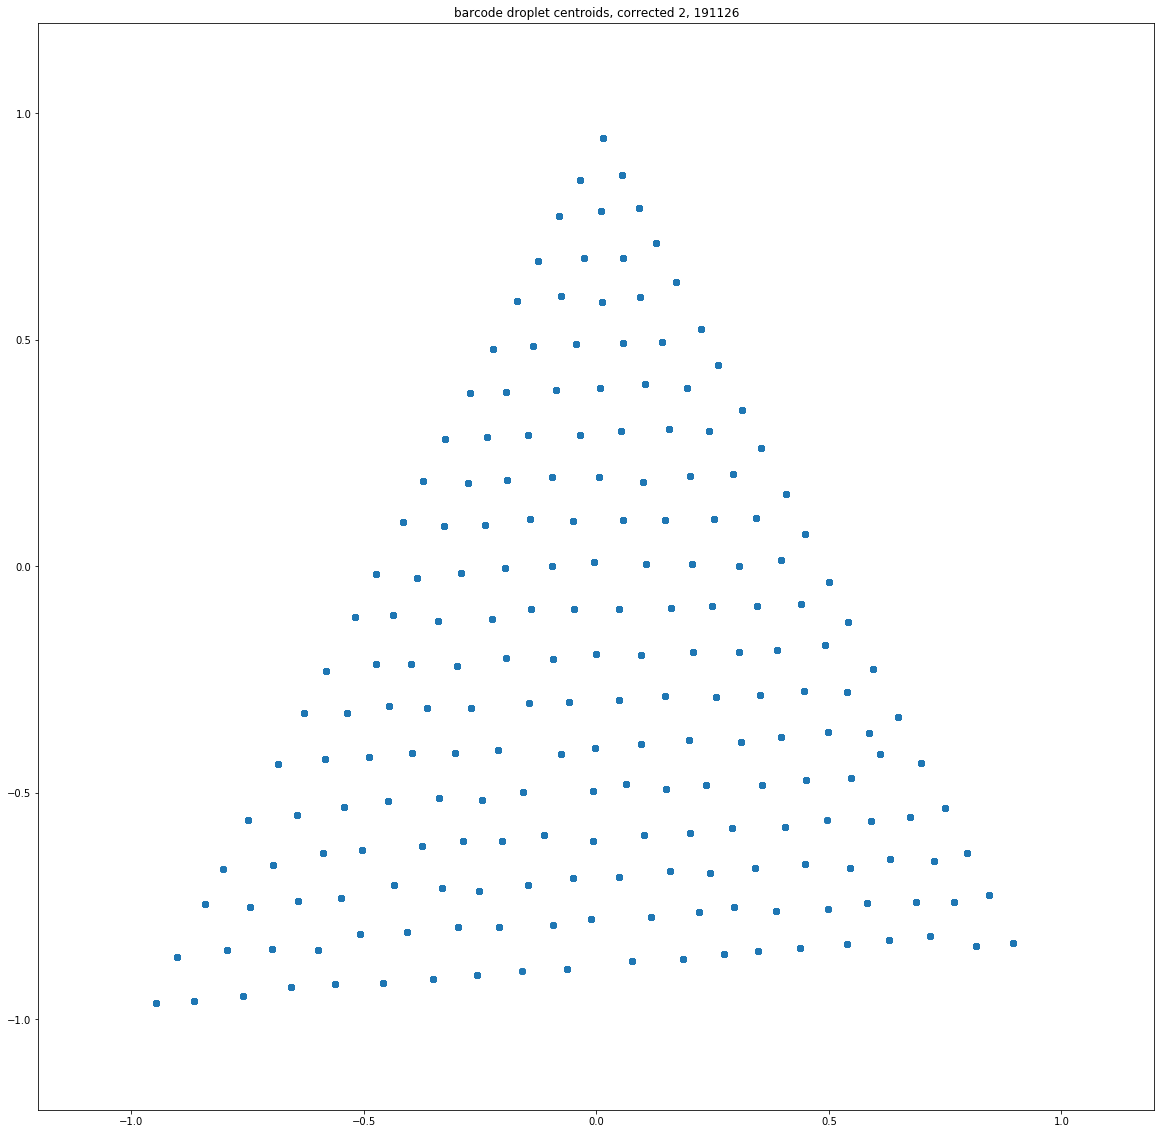

In [16]:
d = droplets.loc[:5e3]
fig,ax = plt.subplots(figsize=(20,20))
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.2,1.2)
plt.scatter(d['CentroidX'],d['CentroidY'])
plt.title('barcode droplet centroids, corrected 2, 191126')
plt.savefig('191028_droplet_centroids_chip1.png',bbox_inches='tight')
